## Structuring the task directory

In this section, we will copy and rename our images according to the structure required by nn-UNet. Both train and validation images will be transfered to imagesTr, the corresponding labels to labelsTr, whereas the test images will be stored in imagesTs.

<!-- - Task501 - Old preproc NCCT APIS
- Task502 - Old preproc ADC APIS
- Task503 - NCCT APIS
- Task504 - ADC APIS
- Task505 - NCCT AISD
- Task506 - DWI AISD -->

New experiments:

AUTOTUNING:
- 001: TUM gold
- 002: TUM gold+silver
- 003: TUM gold+silver wo small
- 004: APIS+TUM
- 005: AISD+TUM
- 006: AISD+APIS+TUM

- 007: TUM+FLIP
- 008: TUM+DIFF
- 009: TUM+VASC
- 010: TUM+STSEG
- 011: TUM+DIFF+VASC

VAL SETS
- 012: TUM VAL
- 013: TUM WO SMALL VAL
- 014: APIS VAL
- 015: AISD VAL

- 016: TUM ncct_flip VAL
- 017: TUM new_diff VAL
- 018: TUM new_vasc VAL
- 019: TUM new_stseg VAL
- 020: TUM diff+vasc VAL
- 021: TUM+APIS+AISD diff
- 022: APIS VAL


In [2]:
# export nnUnet_plans='/home/jseia/Desktop/thesis/code/nnUNet/nnunetv2/nnUNet_trained_models/Dataset001_AIS/nnUNetTrainer_100epochs__nnUNetPlans__3d_fullres'
# !nnUNetv2_predict -i -o -d -p nnUnet_plans -tr nnUNetTrainer_100epochs -c 3d_fullres -f 0 -chk checkpoint_best.pth

In [1]:
import os
from pathlib import Path

datapath = Path('/home/jseia/Desktop/thesis/data/')
base_path = Path('/home/jseia/Desktop/thesis/code/nnUNet/nnunetv2')
os.environ['nnUNet_raw'] = str(base_path/'nnUNet_raw')
os.environ['nnUNet_preprocessed'] = str(base_path/'preprocessed')
os.environ['nnUNet_results'] = str(base_path/'nnUNet_trained_models')

In [2]:
from nnunetv2.dataset_conversion.generate_dataset_json import generate_dataset_json
from nnunetv2.paths import nnUNet_raw
from batchgenerators.utilities.file_and_folder_operations import join

task_id = '023'
task_name = 'AIS'
foldername = f'Dataset{task_id}_{task_name}'

out_base = join(nnUNet_raw, foldername)
imagestr = join(out_base, "imagesTr")
labelstr = join(out_base, "labelsTr")
imagests = join(out_base, 'imagesTs')
labelsts = join(out_base, "labelsTs")

Path(labelstr).mkdir(exist_ok=True, parents=True)
Path(imagestr).mkdir(exist_ok=True, parents=True)
Path(imagests).mkdir(exist_ok=True, parents=True)
Path(labelsts).mkdir(exist_ok=True, parents=True)

ModuleNotFoundError: No module named 'nnunetv2'

## Parsing data

In this section we will copy the raw ISBR data to the corresponding directories as previously explained.

In [4]:
repo_root = Path().resolve().parent
import sys ; sys.path.insert(0, str(repo_root))
from dataset.dataset import StrokeDataset

def get_datasets(datasets, standard):
    train = StrokeDataset(
        datapath=datapath,
        pathology=['ais'],
        datasets=datasets,
        modalities=['ncct', 'ncct-tilt', 'msk', 'msk-tilt'],
        partitions=['train'],
        standard=standard,
        only_filenames=True,
        filter_discard=True
    )

    validation = StrokeDataset(
        datapath=datapath,
        datasets=datasets,
        pathology=['ais'],
        modalities=['ncct', 'ncct-tilt', 'msk', 'msk-tilt'],
        partitions=['validation'],
        standard=standard,
        only_filenames=True,
        filter_discard=True
    )

    test = StrokeDataset(
        datapath=datapath,
        datasets=datasets,
        pathology=['ais'],
        modalities=['ncct', 'ncct-tilt', 'msk', 'msk-tilt'],
        standard=standard,
        partitions=['test'],
        only_filenames=True,
        filter_discard=True
    )

    return train, validation, test

train, validation, test = get_datasets(['apis'], ['gold', 'silver'])

In [28]:
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
from utils.utils import save_img_from_array_using_referece, intensity_clipping, replace_value

def hardcore_fix_images(img_path: Path, ref_path: Path, out_path: Path):
    img = sitk.ReadImage(str(img_path))
    img_array = sitk.GetArrayFromImage(img)
    ref_img = sitk.ReadImage(str(ref_path))
    save_img_from_array_using_referece(img_array, ref_img, out_path)

dsets = [train, validation, test]

for set_dset in dsets:
    for i in tqdm(range(len(set_dset))):
        sample = set_dset[i]
        sample_id = sample['subject']
        suffix = '' if ('tilt' not in sample['ncct']) else '-tilt'
        ncct_path = (datapath/'clean'/sample['dataset_name']/sample['ncct'])
        name = ncct_path.name
        name = ('_').join(name.split('_')[:2])
        ncct_path = ncct_path.parent
        if sample['dataset_name'] == 'tum':
            ncct_path = Path(str(ncct_path).replace('ses-0000', 'ses-0001'))
            name = name.replace('ses-0000', 'ses-0001')
        dwi_path = ncct_path / f'{name}_dwi-pp.nii.gz'
        adc_path = ncct_path / f'{name}_adc-pp.nii.gz'
        msk_path = ncct_path / f'{name}_msk-pp.nii.gz'
        if sample['dataset_name'] == 'tum':
            ncct_path = Path(str(ncct_path).replace('ses-0001', 'ses-0000'))
            name = name.replace('ses-0001', 'ses-0000')
        ncct_flip_path = ncct_path / f'{name}_ncct-pp-flip.nii.gz'
        ncct_path = ncct_path / f'{name}_ncct-pp.nii.gz'

        intensity_clipping(ncct_flip_path, ncct_flip_path, v_min=-100, v_max=400)
        # intensity_clipping(ncct_path, ncct_path, v_min=-100, v_max=400)
        # if adc_path.exists():
        #     replace_value(adc_path, dwi_path, -1000, 0)
        # if dwi_path.exists():
        #     replace_value(dwi_path, dwi_path, -1000, 0)
        # hardcore_fix_images(msk_path, ncct_path, msk_path)
        # msk_path = ncct_path / f'{name}_msk-pp.nii.gz'

100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


In [34]:
from scipy import ndimage
from utils.utils import save_img_from_array_using_referece
import SimpleITK as sitk
import numpy as np


def remove_small_lesions(mask_path: Path, output_path: Path, min_les_vol: float = 3.5) -> None:
    mask = sitk.ReadImage(str(mask_path))
    mask_array = sitk.GetArrayFromImage(mask)
    voxel_size = mask.GetSize()
    unit_volume = voxel_size[0] * voxel_size[1] * voxel_size[2]

    label_img, _ = ndimage.label(mask_array, structure=np.ones((3, 3, 3)))
    label, counts = np.unique(label_img, return_counts=True)
    volumes = counts * unit_volume
    labels_to_ignore = label[volumes <= min_les_vol]
    if len(labels_to_ignore) != 0:
        for i in labels_to_ignore:
            label_img[label_img == i] = 0
        mask_array = np.where(label_img != 0, 1, 0).astype('int')
    save_img_from_array_using_referece(mask_array, mask, output_path)

In [5]:
from tqdm import tqdm
import shutil

dsets = [train, validation, test]
data_dirs = [Path(imagestr), Path(imagestr), Path(imagests)]
labels_dirs = [Path(labelstr), Path(labelstr), Path(labelsts)]

# dsets = [test]
# data_dirs = [Path(imagests)]
# labels_dirs = [Path(labelsts)]

dsets = [validation]
data_dirs = [Path(imagestr)]
labels_dirs = [Path(labelstr)]

for set_dset, set_dir, lab_dir in zip(dsets, data_dirs, labels_dirs):
    for i in tqdm(range(len(set_dset))):
        sample = set_dset[i]
        sample_id = sample['subject']
        if sample_id in ['strokeperf0052', '0072762', '0072681']:
            continue
        ncct_path = (datapath/'clean'/sample['dataset_name']/sample['ncct'])
        name = ncct_path.name
        name = ('_').join(name.split('_')[:2])
        ncct_path = ncct_path.parent
        if sample['dataset_name'] == 'tum':
            ncct_path = Path(str(ncct_path).replace('ses-0000', 'ses-0001'))
            name = name.replace('ses-0000', 'ses-0001')
        dwi_path = ncct_path / f'{name}_dwi-pp.nii.gz'
        adc_path = ncct_path / f'{name}_adc-pp.nii.gz'
        msk_path = ncct_path / f'{name}_msk-pp.nii.gz'
        if sample['dataset_name'] == 'tum':
            ncct_path = Path(str(ncct_path).replace('ses-0001', 'ses-0000'))
            name = name.replace('ses-0001', 'ses-0000')
        ncct_path_flip = ncct_path / f'{name}_ncct-pp-flip.nii.gz'
        diff_path = ncct_path / f'{name}_diff.nii.gz'
        vasc_path = ncct_path / f'{name}_vasc-pp.nii.gz'
        stseg_path = ncct_path / f'{name}_stseg.nii.gz'
        ncct_path = ncct_path / f'{name}_ncct-pp.nii.gz'
        
        new_ncct_name = f'{sample_id}_0000.nii.gz'
        new_ncct_flip_name = f'{sample_id}_0001.nii.gz'
        new_diff_name = f'{sample_id}_0002.nii.gz'
        new_vasc_name = f'{sample_id}_0003.nii.gz'
        new_stseg_name = f'{sample_id}_0004.nii.gz'
        
        new_mask_name = f'{sample_id}.nii.gz'

        # copy image to task folder
        shutil.copyfile(ncct_path, set_dir/new_ncct_name)
        # remove_small_lesions(msk_path, lab_dir/new_mask_name)
        shutil.copyfile(msk_path, lab_dir/new_mask_name)
        
        # shutil.copyfile(ncct_path_flip, set_dir/new_ncct_flip_name)
        shutil.copyfile(diff_path, set_dir/new_diff_name)
        # shutil.copyfile(vasc_path, set_dir/new_vasc_name)
        # shutil.copyfile(stseg_path, set_dir/new_stseg_name)

100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Creating the dataset.json file required by nn-UNet which contains information about our custom dataset.

In [6]:
exclude = ['strokeperf0052', '0072762', '0072681']
train_list = [i for i in train.df.subject.tolist() if i not in exclude]
val_list = [i for i in validation.df.subject.tolist() if i not in exclude]
generate_dataset_json(
    out_base,
    channel_names={0: 'CT', 2: 'rescale_to_0_1'}, # 3: 'rescale_to_0_1'},
    labels={'background': 0, 'ais': 1},
    num_training_cases=len(val_list),
    file_ending='.nii.gz'
)

The last step of this section is to check if the structure of our dataset directory is compatible with nn-UNet's requirements.

In [7]:
#running it from the experiment_planning folder to verify the path settings
# !python /home/jseia/Desktop/thesis/code/nnUNet/nnunet/experiment_planning/nnUNet_plan_and_preprocess.py -t 5015 --verify_dataset_integrity
!nnUNetv2_plan_and_preprocess -d 022 --verify_dataset_integrity

Fingerprint extraction...
Dataset022_AIS
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
WARNING! Not all input images have the same direction!
Directions:
[(0.999691823636911, 0.005301544388477902, 0.02425183392825337, 0.004936973463830356, -0.9998742835641078, 0.015067958502985165, -0.02432866717525709, 0.014943583715401517, 0.9995923194871341), (0.9996918271692398, 0.005301785575647835, 0.024251634654973715, 0.004937212365511116, -0.9998742787786951, 0.015068197871377682, -0.02432847354612817, 0.014943818337166587, 0.999592320713535)]
Image files:
['/home/jseia/Desktop/thesis/code/nnUNet/nnunetv2/nnUNet_raw/Dataset022_AIS/imagesTr/train041_0000.nii.gz', '/home/jseia/Desktop/thesis/code/nnUNet/nnunetv2/nnUNet_raw/Dataset022_AIS/imagesTr/train041_0002.nii.gz']
It is up to you to decide whether that's a problem. You should run nnUNet_plot_dataset_pngs to verify that segmentations and data overlap.
WARNING! Not all input images have the same directi

## Creating Train-Val split

By default, nn-UNet creates a 5-fold cross-validation splits (5 folds). However, for this first task we would like to train using the original split of the IBSR dataset and compare the results obtained on the validation set. This is due to the heavy computation of the 3D full-resolution UNet which makes it hard to train for 5 folds.

We create a dictionary that contains two lists, train and validation, with the corresponding image IDs as provided in the challenge dataset. This dictionary will later be saved using pickle and used by nnUnet to train the models.

In [8]:
exclude = [] # ['strokeperf0052']
train_list = [i for i in train.df.subject.tolist() if i not in exclude]
val_list = [i for i in validation.df.subject.tolist() if i not in exclude]
print(len(train_list))
print(len(val_list))

30
7


In [9]:
from batchgenerators.utilities.file_and_folder_operations import save_json

splits = [{'train': train_list, 'val': val_list}]
save_json(splits, '/home/jseia/Desktop/thesis/code/nnUNet/nnunetv2/preprocessed/Dataset022_AIS/splits_final.json')

## Visualization

Now we will visualize example images from both training and test sets

In [9]:
# #visualizing some of the training images and labels
# # (re-run to see random pick-ups)
# train_img_name = os.listdir(train_image_dir)[np.random.randint(0,10)]
# train_img = np.array(nib.load(os.path.join(train_image_dir,train_img_name)).dataobj)[:,:,100:110]
# train_label_name = train_img_name[:train_img_name.find('_0000.nii.gz')]+'.nii.gz'
# train_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)[:,:,100:110]

# print(train_img.shape,train_label.shape)

# max_rows = 2
# max_cols = train_img.shape[2]

# fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
# for idx in range(max_cols):
#     axes[0, idx].axis("off") 
#     axes[0, idx].set_title('Train Image'+str(idx+1))
#     axes[0 ,idx].imshow(train_img[:,:,idx].squeeze(), cmap="gray")
# for idx in range(max_cols):    
#     axes[1, idx].axis("off")
#     axes[1, idx].set_title('Train Label'+str(idx+1))
#     axes[1, idx].imshow(train_label[:,:,idx].squeeze())

# plt.subplots_adjust(wspace=.1, hspace=.1)
# plt.show()

In [10]:
# #visualizing some of the test images
# # (re-run to see random pick-ups)

# test_img_name = os.listdir(test_dir)[np.random.randint(0,3)]
# test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:,110:115]

# print(test_img.shape)

# max_cols = test_img.shape[2]
# max_rows = 1

# fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,20))
# for idx in range(max_cols):
#     axes[ idx].axis("off") 
#     axes[ idx].set_title('Test Image')
#     axes[ idx].imshow(test_img[:,:,idx].squeeze(), cmap="gray")
    
    
# plt.subplots_adjust(wspace=.1, hspace=.1)
# plt.show()

## Comparison

In this section, we will calculate several metrics from the results obtained on the validation set for each model and compare the results.

In [57]:
val_lists = {} 
_, validation, _ = get_datasets(['apis'])
val_lists['501'] = validation.df.subject.tolist()
val_lists['502'] = validation.df.subject.tolist()
val_lists['503'] = validation.df.subject.tolist()
val_lists['504'] = validation.df.subject.tolist()
val_lists['5013'] = validation.df.subject.tolist()
_, validation, _ = get_datasets(['aisd'])
val_lists['505'] = validation.df.subject.tolist()
val_lists['506'] = validation.df.subject.tolist()
_, validation, _ = get_datasets(['aisd', 'apis'])
val_lists['507'] = validation.df.subject.tolist()
_, validation, _ = get_datasets(['tum'])
p = Path('/home/jseia/Desktop/thesis/code/nnUNet/nnunet/nnUNet_trained_models/nnUNet/3d_fullres/Task509/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed/')
p = [(i.name).replace('.nii.gz', '') for i in list(p.iterdir()) if 'strokeperf' in i.name]
val_lists['509'] = p
p = Path('/home/jseia/Desktop/thesis/code/nnUNet/nnunet/nnUNet_trained_models/nnUNet/3d_fullres/Task5010/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed/')
p = [(i.name).replace('.nii.gz', '') for i in list(p.iterdir()) if 'strokeperf' in i.name]
val_lists['5010'] = p
val_lists['5015'] = validation.df.subject.tolist()
_, validation, _ = get_datasets(['aisd', 'apis', 'tum'])
val_lists['5011'] = validation.df.subject.tolist()


base_gt_path = Path('/home/jseia/Desktop/thesis/code/nnUNet/nnunet/nnUNet_trained_models/nnUNet/3d_fullres/')
gt_paths = {}
gt_paths['501'] = base_gt_path/'Task501/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['502'] = base_gt_path/'Task502/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['503'] = base_gt_path/'Task503/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['504'] = base_gt_path/'Task503/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['505'] = base_gt_path/'Task505/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['506'] = base_gt_path/'Task506/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['507'] = base_gt_path/'Task507/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['509'] = base_gt_path/'Task509/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['5010'] = base_gt_path/'Task5010/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['5011'] = base_gt_path/'Task5011/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['5013'] = base_gt_path/'Task5013/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
gt_paths['5015'] = base_gt_path/'Task5015/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'

base_pred_path = Path('/home/jseia/Desktop/thesis/code/nnUNet/nnunet/nnUNet_trained_models/nnUNet/')
pred_paths = {}
pred_paths['501_2d'] = base_pred_path/'2d/Task501/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['501_3d'] = base_pred_path/'3d_fullres/Task501/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['502_2d'] = base_pred_path/'2d/Task502/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['502_3d'] = base_pred_path/'3d_fullres/Task502/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['503_2d'] = base_pred_path/'2d/Task503/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['503_3d'] = base_pred_path/'3d_fullres/Task503/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['504_2d'] = base_pred_path/'2d/Task504/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['504_3d'] = base_pred_path/'3d_fullres/Task504/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['505_2d'] = base_pred_path/'2d/Task505/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['505_3d'] = base_pred_path/'3d_fullres/Task505/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['506_2d'] = base_pred_path/'2d/Task506/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['506_3d'] = base_pred_path/'3d_fullres/Task506/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['507_2d'] = base_pred_path/'2d/Task507/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['507_3d'] = base_pred_path/'3d_fullres/Task507/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['509_3d'] = base_pred_path/'3d_fullres/Task509/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['5010_3d'] = base_pred_path/'3d_fullres/Task5010/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['5011_3d'] = base_pred_path/'3d_fullres/Task5011/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['5013_3d'] = base_pred_path/'3d_fullres/Task5013/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'
pred_paths['5015_3d'] = base_pred_path/'3d_fullres/Task5015/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/fold_0/validation_raw_postprocessed'

# val_list = ['IBSR_13', 'IBSR_14', 'IBSR_11', 'IBSR_17', 'IBSR_12']
avd_list = []
hd_list = []
ravd_list = []
dice_list = []

In [58]:
for task in [501, 502, 503, 504, 505, 506, 507, 509, 5010, 5013, 5015]:
    modality = 'ncct' if task in [501, 503, 505, 507, 509, 5011, 5013, 5015] else 'mri'
    val_list = val_lists[str(task)]
    gt_path = str(gt_paths[str(task)])
    for mode in ['2d', '3d']:
        if (mode == '2d') and (task in [507, 509, 5010, 5011, 5013, 5015]):
            continue
        preds_path = str(pred_paths[f'{task}_{mode}'])
        for img_id in val_list:
            gt = sitk.ReadImage(f'{gt_path}/{img_id}.nii.gz')
            if 'train' in img_id:
                dataset = 'apis'
            elif 'strokeperf' in img_id:
                dataset = 'tum'
            else:
                dataset = 'aisd'
                
            vspace = gt.GetSpacing()
            gt = sitk.GetArrayFromImage(gt)
            pred = sitk.GetArrayFromImage(sitk.ReadImage(f'{preds_path}/{img_id}.nii.gz'))
            dice_list.append([dice_score(gt, pred)[0].tolist()] + [img_id, f'{mode.upper()} U-Net', modality, task, dataset])

In [59]:
columns = ['Lesion', 'Case', 'Model', 'Modality', 'Task', 'Dataset']
dice_scores_df = pd.DataFrame(data=dice_list, columns=columns)
dice_scores_df.to_csv('dice.csv')

# avd_df = pd.DataFrame(data=avd_list, columns=columns)
# avd_df.to_csv('/content/drive/MyDrive/misa_fp/results/avd.csv')

# ravd_df = pd.DataFrame(data=ravd_list, columns=columns)
# ravd_df.to_csv('/content/drive/MyDrive/misa_fp/results/ravd.csv')

# hd_df = pd.DataFrame(data=hd_list, columns=columns)
# hd_df.to_csv('/content/drive/MyDrive/misa_fp/results/hd.csv')

/tmp/ipykernel_550821/909706627.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Task'] = temp.Task.replace(509, 'NCCT')
/tmp/ipykernel_550821/909706627.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Task'] = temp.Task.replace(5015, 'NCCT+FLIP')


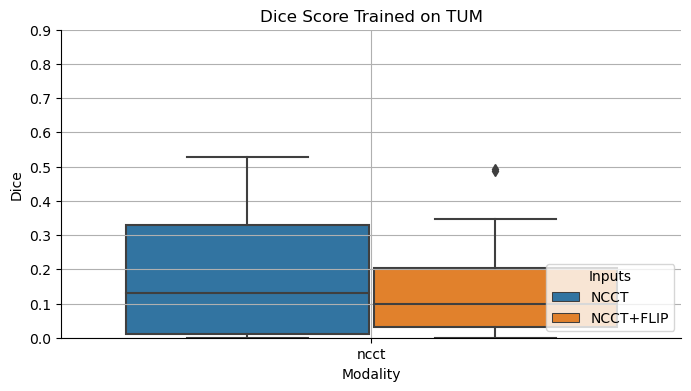

In [61]:
df = pd.melt(dice_scores_df, id_vars=['Model', 'Case', 'Modality', 'Task', 'Dataset'], value_vars=['Lesion'], ignore_index=False)
# print(df.columns)
df.columns = ['Model', 'Case', 'Modality', 'Task', 'Dataset', 'Lesion', 'Dice']

# plt.figure(figsize=(8,4))
# temp = df.loc[(df.Dataset=='apis') & (df.Task.isin([501, 502]))]
# plt.title(f'Dice Score APIS - First training')
# sns.boxplot(data=temp, x="Modality", y="Dice", hue="Model")
# sns.despine()
# plt.ylim([0,0.9])
# plt.grid('h')
# plt.legend(loc='lower right', title='Model')
# plt.show()

# plt.figure(figsize=(8,4))
# temp = df.loc[(df.Dataset=='apis') & (df.Task.isin([503, 504]))]
# plt.title(f'Dice Score APIS - Preprocessing fixed')
# sns.boxplot(data=temp, x="Modality", y="Dice", hue="Model")
# sns.despine()
# plt.ylim([0,0.9])
# plt.grid('h')
# plt.legend(loc='lower right', title='Model')
# plt.show()

# plt.figure(figsize=(8,4))
# temp = df.loc[(df.Dataset=='aisd') & (df.Task.isin([505, 506]))]
# plt.title(f'Dice Score AISD')
# sns.boxplot(data=temp, x="Modality", y="Dice", hue="Model")
# sns.despine()
# plt.ylim([0,0.9])
# plt.grid('h')
# plt.legend(loc='lower right', title='Model')
# plt.show()

# plt.figure(figsize=(8,4))
# temp = df.loc[(df.Dataset=='apis') & (df.Task.isin([503, 507])) & (df.Model=='3D U-Net')]
# temp['Task'] = temp.Task.replace(503, 'APIS')
# temp['Task'] = temp.Task.replace(505, 'AISD')
# temp['Task'] = temp.Task.replace(507, 'AISD+APIS')
# plt.title(f'Dice Score Trained with APIS+AISD results for APIS val set (3D)')
# sns.boxplot(data=temp, x="Dataset", y="Dice", hue="Task")
# sns.despine()
# plt.ylim([0,0.9])
# plt.grid('h')
# plt.legend(loc='lower right', title='Dataset used to train')
# plt.show()

# plt.figure(figsize=(8,4))
# temp = df.loc[(df.Dataset=='aisd') & (df.Task.isin([505, 507])) & (df.Model=='3D U-Net')]
# temp['Task'] = temp.Task.replace(503, 'APIS')
# temp['Task'] = temp.Task.replace(505, 'AISD')
# temp['Task'] = temp.Task.replace(507, 'AISD+APIS')
# plt.title(f'Dice Score Trained with APIS+AISD results for AISD val set (3D)')
# sns.boxplot(data=temp, x="Dataset", y="Dice", hue="Task")
# sns.despine()
# plt.ylim([0,0.9])
# plt.grid('h')
# plt.legend(loc='lower right', title='Dataset used to train')
# plt.show()

# # plt.figure(figsize=(8,4))
# # temp = df.loc[(df.Model.isin(['3D U-Net'])) & ((df.Task.isin([501, 505, 507])))]
# # temp['Task'] = temp.Task.replace(503, 'APIS')
# # temp['Task'] = temp.Task.replace(505, 'AISD')
# # temp['Task'] = temp.Task.replace(507, 'BOTH')
# # plt.title(f'Dice Scores on validation set of three experiments')
# # sns.boxplot(data=temp, x="Modality", y="Dice", hue="Task")
# # sns.despine()
# # plt.ylim([0,0.9])
# # plt.grid('h')
# # plt.legend(loc='lower right', title='Dataset used to train')
# # plt.show()

# plt.figure(figsize=(8,4))
# temp = df.loc[(df.Task.isin([509, 5010]))]
# plt.title(f'Dice Score Trained on TUM')
# sns.boxplot(data=temp, x="Modality", y="Dice", hue="Model")
# sns.despine()
# plt.ylim([0,0.9])
# plt.grid('h')
# plt.legend(loc='lower right', title='Model')
# plt.show()

# plt.figure(figsize=(8,4))
# temp = df.loc[(df.Task.isin([503, 5013])) & (df.Model=='3D U-Net')]
# temp['Task'] = temp.Task.replace(503, 'NCCT')
# temp['Task'] = temp.Task.replace(5013, 'NCCT+FLIP')
# plt.title(f'Dice Score Trained on APIS')
# sns.boxplot(data=temp, x="Modality", y="Dice", hue="Task")
# sns.despine()
# plt.ylim([0,0.9])
# plt.grid('h')
# plt.legend(loc='lower right', title='Inputs')
# plt.show()

plt.figure(figsize=(8,4))
temp = df.loc[(df.Task.isin([509, 5015])) & (df.Model=='3D U-Net')]
temp['Task'] = temp.Task.replace(509, 'NCCT')
temp['Task'] = temp.Task.replace(5015, 'NCCT+FLIP')
plt.title(f'Dice Score Trained on TUM')
sns.boxplot(data=temp, x="Modality", y="Dice", hue="Task")
sns.despine()
plt.ylim([0,0.9])
plt.grid('h')
plt.legend(loc='lower right', title='Inputs')
plt.show()


In [ ]:
df[['Model', 'Tissue', 'Dice',]].groupby(['Model', 'Tissue']).mean()

Dice
Model    Tissue          
2D U-Net CSF     0.909105
         GM      0.950853
         WM      0.940484
3D U-Net CSF     0.906772
         GM      0.948705
         WM      0.934876

In [ ]:
df[['Model', 'Tissue', 'Dice',]].groupby(['Model', 'Tissue']).std()

Dice
Model    Tissue          
2D U-Net CSF     0.022970
         GM      0.007502
         WM      0.010957
3D U-Net CSF     0.022052
         GM      0.009138
         WM      0.010518

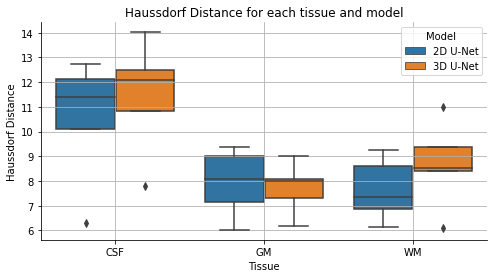

In [ ]:
df = pd.melt(hd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'Haussdorf Distance']

plt.figure(figsize=(8,4))
plt.title('Haussdorf Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="Haussdorf Distance", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'Haussdorf Distance',]].groupby(['Model', 'Tissue']).mean()

Haussdorf Distance
Model    Tissue                    
2D U-Net CSF              10.531409
         GM                7.923903
         WM                7.639348
3D U-Net CSF              11.440340
         GM                7.714956
         WM                8.684301

In [ ]:
df[['Model', 'Tissue', 'Haussdorf Distance',]].groupby(['Model', 'Tissue']).std()

Haussdorf Distance
Model    Tissue                    
2D U-Net CSF               2.568064
         GM                1.373132
         WM                1.258520
3D U-Net CSF               2.340071
         GM                1.047921
         WM                1.770859

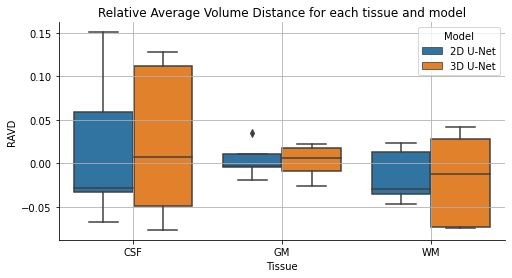

In [ ]:
df = pd.melt(ravd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'RAVD']

plt.figure(figsize=(8,4))
plt.title('Relative Average Volume Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="RAVD", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'RAVD',]].groupby(['Model', 'Tissue']).mean()

RAVD
Model    Tissue          
2D U-Net CSF     0.016166
         GM      0.003866
         WM     -0.014896
3D U-Net CSF     0.024168
         GM      0.002371
         WM     -0.017889

In [ ]:
df[['Model', 'Tissue', 'RAVD',]].groupby(['Model', 'Tissue']).std()

RAVD
Model    Tissue          
2D U-Net CSF     0.088367
         GM      0.020358
         WM      0.030999
3D U-Net CSF     0.092643
         GM      0.019737
         WM      0.054735

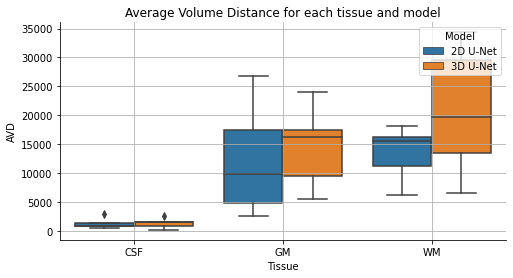

In [ ]:
df = pd.melt(avd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'AVD']

plt.figure(figsize=(8,4))
plt.title('Average Volume Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="AVD", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'AVD',]].groupby(['Model', 'Tissue']).mean()

AVD
Model    Tissue              
2D U-Net CSF      1283.210217
         GM      12294.718501
         WM      13440.907087
3D U-Net CSF      1316.327510
         GM      14543.325830
         WM      20706.621872

In [ ]:
df[['Model', 'Tissue', 'AVD',]].groupby(['Model', 'Tissue']).std()

AVD
Model    Tissue              
2D U-Net CSF       989.019570
         GM       9949.644415
         WM       4783.076781
3D U-Net CSF       889.805790
         GM       7260.412427
         WM      11403.443124

We can see that overall, 2D U-Net performs slightly better than the 3D full-resolution U-Net. It is also faster to train. We will proceed with 2D U-Net for the next tasks.

# Task 2: 2D U-Net with Full Data and 5-Fold CV

In this task (ID=505), we will retrain the 2D U-Net with 5-Fold cross validation. This will give better insight on the model's performance than the classical train-validation set approach. It will also enable the selection of post-processing techniques by the nn-UNet framework (this is not done if the model is not trained with 5-fold CV). The same steps followed in the previous task will be followed in this one. The only difference is that we will train for 5 folds instead of 1.

## Structuring the task directory

In [ ]:
task_name = 'Task505_misa_fp' 
nnunet_dir = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
main_dir = os.path.join(base_dir,'nnUNet/nnunet')

In [ ]:
make_if_dont_exist(task_folder_name,overwrite = False)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir,overwrite= False)
make_if_dont_exist(os.path.join(main_dir,'nnunet_trained_models'))

nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task505_misa_fp exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task505_misa_fp/imagesTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task505_misa_fp/labelsTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task505_misa_fp/imagesTs exists.
/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnunet_trained_models exists.


## Environment variables

In [ ]:
os.environ['nnUNet_raw_data_base'] = os.path.join(main_dir,'nnUNet_raw_data_base')
os.environ['nnUNet_preprocessed'] = os.path.join(main_dir,'preprocessed')
os.environ['RESULTS_FOLDER'] = os.path.join(main_dir,'nnUNet_trained_models')

## Parsing the data

In [ ]:
train_dir = '/content/drive/MyDrive/misa_fp/data/Training_Set'
val_dir = '/content/drive/MyDrive/misa_fp/data/Validation_Set'
test_dir_or = '/content/drive/MyDrive/misa_fp/data/Test_Set'

In [ ]:
for sample_id in os.listdir(train_dir):
  sample_location = os.path.join(train_dir, sample_id)
  img_name = f'{sample_id}.nii.gz'
  mask_name = f'{sample_id}_seg.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality
  new_mask_name = f'{sample_id}.nii.gz'

  # copy image to task folder
  copy_and_rename(sample_location, img_name, train_image_dir, new_img_name)
  # copy label to task folder
  copy_and_rename(sample_location, mask_name, train_label_dir, new_mask_name)
  print(f'{sample_id} copied')

IBSR_03 copied
IBSR_09 copied
IBSR_05 copied
IBSR_04 copied
IBSR_16 copied
IBSR_06 copied
IBSR_08 copied
IBSR_01 copied
IBSR_07 copied
IBSR_18 copied


In [ ]:
for sample_id in os.listdir(val_dir):
  sample_location = os.path.join(val_dir, sample_id)
  img_name = f'{sample_id}.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality

  # copy image to task folder
  copy_and_rename(sample_location, img_name, test_dir, new_img_name)

  print(f'{sample_id} copied')

IBSR_13 copied
IBSR_14 copied
IBSR_11 copied
IBSR_17 copied
IBSR_12 copied


In [ ]:
for sample_id in os.listdir(test_dir_or):
  sample_location = os.path.join(test_dir_or, sample_id)
  img_name = f'{sample_id}.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality

  # copy image to task folder
  copy_and_rename(sample_location, img_name, test_dir, new_img_name)

  print(f'{sample_id} copied')

IBSR_02 copied
IBSR_10 copied
IBSR_15 copied


Creating dataset.json

In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['description'] = "MISA Final Project Dataset: Brain tissue segmentation from MRI, 2D with all data"
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = "see challenge website"
    json_dict['licence'] = "see challenge website"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['modality'] = {
        "0": "MRI"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "0": "background",
        "1": "CSF",
        "2": "GM",
        "3": "WM"
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    #removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]

    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


Check dataset

In [ ]:
#running it from the experiment_planning folder to verify the path settings
os.chdir(main_dir)
!python experiment_planning/nnUNet_plan_and_preprocess.py -t 505 --verify_dataset_integrity
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case IBSR_03
checking case IBSR_09
checking case IBSR_16
checking case IBSR_05
checking case IBSR_06
checking case IBSR_04
checking case IBSR_18
checking case IBSR_08
checking case IBSR_01
checking case IBSR_07
Verifying label values
Expected label values are [0, 1, 2, 3]
Labels OK
Verifying test set
Dataset OK
IBSR_03
IBSR_09
IBSR_16
IBSR_05
IBSR_06
IBSR_04
IBSR_18
IBSR_08
IBSR_01
IBSR_07



 Task505_misa_fp
number of threads:  (8, 8) 

using nonzero mask for normalization
Are we using the nonzero mask for normalization? OrderedDict([(0, True)])
the median shape of the dataset is  [138.83333333 115

## Train

### Fold 1

In [ ]:
# First fold => Done
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 505 0
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

### Fold 2

In [ ]:
# Second fold 
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 505 1
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

### Fold 3

In [ ]:
# Third fold
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 505 2
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

### Fold 4

In [ ]:
# Fourth fold (stopped at ep 08)
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 505 3
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

In [ ]:
# Fourth fold (resume from ep 09)
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 505 3 -c
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

### Fold 5

In [ ]:
# Fifth fold
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 505 4
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

## Inference on the validation set

In [ ]:
!nnUNet_determine_postprocessing -t 505 -m 2d



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Foreground vs background
before: 0.9274546279750591
after:  0.9274555967721589
Removing all but the largest foreground region improved results!
for_which_classes [1, 2, 3]
min_valid_object_sizes None
1
before: 0.9014124858184116
after:  0.8491021605458385
2
before: 0.9441651134648674
after:  0.9441834291955112
Removing all but the largest region for class 2 improved results!
min_valid_object_sizes None
3
before: 0.9367891910331977
after:  0.8914616946170557
done
for which classes:
[[1, 2, 3], 2]
min_object_sizes
None
done


In [ ]:
result_dir = os.path.join(main_dir,'nnUNet_Predictions', task_name)
make_if_dont_exist(result_dir)
team_name = 'JoaKaou'
#location where you want save your results, will be created if dont exist
os.chdir(main_dir)
!nnUNet_predict -i /content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task505_misa_fp/imagesTs -o nnUNet_Predictions/Task505_misa_fp -t 505 -tr nnUNetTrainerV2 -m 2d --num_threads_preprocessing 1
os.chdir(base_dir)

/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_Predictions/Task505_misa_fp created!


Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task505_misa_fp/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 8 unique case ids, here are some examples: ['IBSR_14' 'IBSR_14' 'IBSR_15' 'IBSR_13' 'IBSR_02' 'IBSR_14' 'IBSR_15'
 'IBSR_02']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 8
number of cases that still need to be predicted: 8
emptying cuda cache
loading parameters fo

# Task 3: 2D-UNet + Bias field correction

In this task (ID=508), we will train the model with the images after applying bias field correction using n4 from SimpleITK.

## Structuring the task directory

In [ ]:
task_name = 'Task508_misa_fp' 
nnunet_dir = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
main_dir = os.path.join(base_dir,'nnUNet/nnunet')

In [ ]:
make_if_dont_exist(task_folder_name,overwrite = False)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir,overwrite= False)
make_if_dont_exist(os.path.join(main_dir,'nnunet_trained_models'))

nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task508_misa_fp exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task508_misa_fp/imagesTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task508_misa_fp/labelsTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task508_misa_fp/imagesTs exists.
/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnunet_trained_models exists.


## Environment variables

In [ ]:
os.environ['nnUNet_raw_data_base'] = os.path.join(main_dir,'nnUNet_raw_data_base')
os.environ['nnUNet_preprocessed'] = os.path.join(main_dir,'preprocessed')
os.environ['RESULTS_FOLDER'] = os.path.join(main_dir,'nnUNet_trained_models')

## Parsing the data

In [ ]:
train_dir = '/content/drive/MyDrive/misa_fp/data_preprocessed/train_set_n4'
val_dir = '/content/drive/MyDrive/misa_fp/data_preprocessed/val_set_n4'
test_dir_or = '/content/drive/MyDrive/misa_fp/data_preprocessed/test_set_n4'

In [ ]:
for sample_id in os.listdir(train_dir):
  sample_location = os.path.join(train_dir, sample_id)
  img_name = f'{sample_id}_n4.nii.gz'
  mask_name = f'{sample_id}_seg.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality
  new_mask_name = f'{sample_id}.nii.gz'

  # copy image to task folder
  copy_and_rename(sample_location, img_name, train_image_dir, new_img_name)
  # copy label to task folder
  copy_and_rename(sample_location, mask_name, train_label_dir, new_mask_name)
  print(f'{sample_id} copied')

In [ ]:
for sample_id in os.listdir(val_dir):
  sample_location = os.path.join(val_dir, sample_id)
  img_name = f'{sample_id}_n4.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality

  # copy image to task folder
  copy_and_rename(sample_location, img_name, test_dir, new_img_name)

  print(f'{sample_id} copied')

In [ ]:
for sample_id in os.listdir(test_dir_or):
  sample_location = os.path.join(test_dir_or, sample_id)
  img_name = f'{sample_id}_n4.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality

  # copy image to task folder
  copy_and_rename(sample_location, img_name, test_dir, new_img_name)

  print(f'{sample_id} copied')

IBSR_02 copied
IBSR_10 copied
IBSR_15 copied


Creating dataset.json

In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['description'] = "MISA Final Project Dataset: Brain tissue segmentation from MRI, 2D with all data, bias field corrected"
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = "see challenge website"
    json_dict['licence'] = "see challenge website"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['modality'] = {
        "0": "MRI"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "0": "background",
        "1": "CSF",
        "2": "GM",
        "3": "WM"
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    #removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]

    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


Check dataset

In [ ]:
#running it from the experiment_planning folder to verify the path settings
os.chdir(main_dir)
!python experiment_planning/nnUNet_plan_and_preprocess.py -t 508 --verify_dataset_integrity
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case IBSR_09
checking case IBSR_08
checking case IBSR_06
checking case IBSR_01
checking case IBSR_05
checking case IBSR_18
checking case IBSR_04
checking case IBSR_16
checking case IBSR_07
checking case IBSR_03
Verifying label values
Expected label values are [0, 1, 2, 3]
Labels OK
Verifying test set
Dataset OK
IBSR_09
IBSR_08
IBSR_06
IBSR_01
IBSR_05
IBSR_18
IBSR_04
IBSR_16
IBSR_07
IBSR_03



 Task508_misa_fp
number of threads:  (8, 8) 

using nonzero mask for normalization
Are we using the nonzero mask for normalization? OrderedDict([(0, True)])
the median shape of the dataset is  [138.83333333 115

## Train

### Fold 1

In [ ]:
# First fold 
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 508 0
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

### Fold 2

In [ ]:
# Second fold 
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 508 1
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

### Fold 3

In [ ]:
# Third fold
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 508 2
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

### Fold 4

In [ ]:
# Fourth fold
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 508 3
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

### Fold 5

In [ ]:
# Fifth fold
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Faster 508 4
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Faster.nnUNetTrainerV2_Faster'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 45, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 144]), 'current_s

## Inference on the validation set

In [ ]:
!nnUNet_determine_postprocessing -t 508 -m 2d



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Foreground vs background
before: 0.9241120198277898
after:  0.924112906226869
Removing all but the largest foreground region improved results!
for_which_classes [1, 2, 3]
min_valid_object_sizes None
1
before: 0.8999759430913772
after:  0.8423231030499707
2
before: 0.9419115478154512
after:  0.9419253831181029
Removing all but the largest region for class 2 improved results!
min_valid_object_sizes None
3
before: 0.9304512277737785
after:  0.8844829227927052
done
for which classes:
[[1, 2, 3], 2]
min_object_sizes
None
done


In [ ]:
result_dir = os.path.join(main_dir,'nnUNet_Predictions', task_name)
make_if_dont_exist(result_dir)
team_name = 'JoaKaou'
#location where you want save your results, will be created if dont exist
os.chdir(main_dir)
!nnUNet_predict -i /content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task508_misa_fp/imagesTs -o nnUNet_Predictions/Task508_misa_fp -t 508 -tr nnUNetTrainerV2 -m 2d --num_threads_preprocessing 1
os.chdir(base_dir)

/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_Predictions/Task508_misa_fp exists.


Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task508_misa_fp/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 8 unique case ids, here are some examples: ['IBSR_15' 'IBSR_17' 'IBSR_10' 'IBSR_10' 'IBSR_10' 'IBSR_13' 'IBSR_15'
 'IBSR_10']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 8
number of cases that still need to be predicted: 8
emptying cuda cache
loading parameters for

# Comparison: Task 2 Vs Task 3

In [ ]:
gt_path = '/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task503_misa_fp/nnUNetTrainerV2_Fast__nnUNetPlansv2.1/gt_niftis'
preds_path_2 = '/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_Predictions/Task505_misa_fp'
preds_path_3 = '/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_Predictions/Task508_misa_fp'
img_list = ['IBSR_13', 'IBSR_14', 'IBSR_11', 'IBSR_17', 'IBSR_12']
avd_list = []
hd_list = []
ravd_list = []
dice_list = []

In [ ]:
# Task 2
for img_id in img_list:
  gt = sitk.ReadImage(f'{gt_path}/{img_id}.nii.gz')
  vspace = gt.GetSpacing()
  gt = sitk.GetArrayFromImage(gt)
  pred = sitk.GetArrayFromImage(sitk.ReadImage(f'{preds_path_2}/{img_id}.nii.gz'))

  hd_list.append(haussdorf(gt, pred, vspace) + [img_id , 'nn-UNet'])
  avd_list.append(avd(gt, pred, vspace) + [img_id, 'nn-UNet'])
  ravd_list.append(rel_abs_vol_dif(gt, pred) + [img_id, 'nn-UNet'])
  dice_list.append(dice_score(gt, pred) + [img_id, 'nn-UNet'])

# Task 3
for img_id in img_list:
  gt = sitk.ReadImage(f'{gt_path}/{img_id}.nii.gz')
  vspace = gt.GetSpacing()
  gt = sitk.GetArrayFromImage(gt)
  pred = sitk.GetArrayFromImage(sitk.ReadImage(f'{preds_path_3}/{img_id}.nii.gz'))

  hd_list.append(haussdorf(gt, pred, vspace) + [img_id , 'N4+nn-UNet'])
  avd_list.append(avd(gt, pred, vspace) + [img_id, 'N4+nn-UNet'])
  ravd_list.append(rel_abs_vol_dif(gt, pred) + [img_id, 'N4+nn-UNet'])
  dice_list.append(dice_score(gt, pred) + [img_id, 'N4+nn-UNet'])

In [ ]:
columns = ['CSF', 'GM', 'WM', 'Case', 'Model']
dice_scores_df = pd.DataFrame(data=dice_list, columns=columns)
dice_scores_df.to_csv('/content/drive/MyDrive/misa_fp/results/dice_n4_0.csv')

avd_df = pd.DataFrame(data=avd_list, columns=columns)
avd_df.to_csv('/content/drive/MyDrive/misa_fp/results/avd_n4_0.csv')

ravd_df = pd.DataFrame(data=ravd_list, columns=columns)
ravd_df.to_csv('/content/drive/MyDrive/misa_fp/results/ravd_n4_0.csv')

hd_df = pd.DataFrame(data=hd_list, columns=columns)
hd_df.to_csv('/content/drive/MyDrive/misa_fp/results/hd_n4_0.csv')

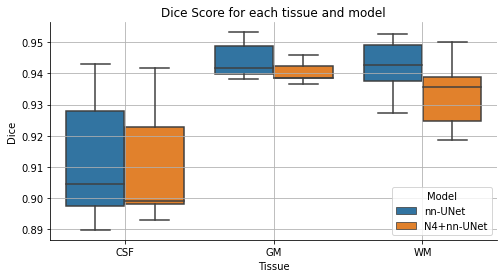

In [ ]:
df = pd.melt(dice_scores_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'Dice']

plt.figure(figsize=(8,4))
plt.title('Dice Score for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="Dice", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'Dice',]].groupby(['Model', 'Tissue']).mean()

Dice
Model      Tissue          
N4+nn-UNet CSF     0.910969
           GM      0.940385
           WM      0.933571
nn-UNet    CSF     0.912546
           GM      0.944376
           WM      0.941761

In [ ]:
df[['Model', 'Tissue', 'Dice',]].groupby(['Model', 'Tissue']).std()

Dice
Model      Tissue          
N4+nn-UNet CSF     0.020681
           GM      0.003711
           WM      0.012324
nn-UNet    CSF     0.022111
           GM      0.006359
           WM      0.010028

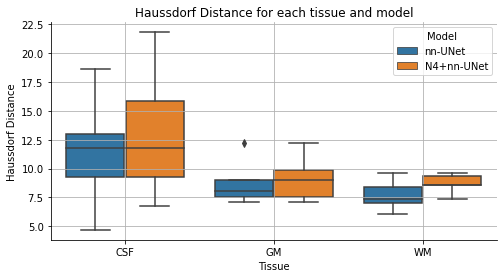

In [ ]:
df = pd.melt(hd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'Haussdorf Distance']

plt.figure(figsize=(8,4))
plt.title('Haussdorf Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="Haussdorf Distance", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'Haussdorf Distance',]].groupby(['Model', 'Tissue']).mean()

Haussdorf Distance
Model      Tissue                    
N4+nn-UNet CSF              13.092009
           GM                9.164337
           WM                8.704843
nn-UNet    CSF              11.461246
           GM                8.805988
           WM                7.686890

In [ ]:
df[['Model', 'Tissue', 'Haussdorf Distance',]].groupby(['Model', 'Tissue']).std()

Haussdorf Distance
Model      Tissue                    
N4+nn-UNet CSF               5.925449
           GM                2.039702
           WM                0.896637
nn-UNet    CSF               5.105343
           GM                2.040761
           WM                1.351024

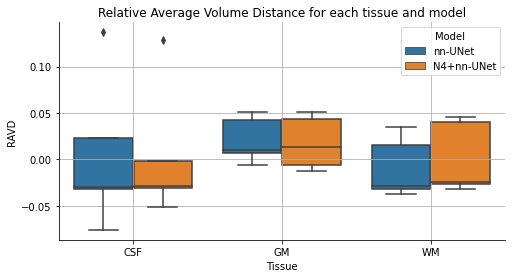

In [ ]:
df = pd.melt(ravd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'RAVD']

plt.figure(figsize=(8,4))
plt.title('Relative Average Volume Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="RAVD", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'RAVD',]].groupby(['Model', 'Tissue']).mean()

RAVD
Model      Tissue          
N4+nn-UNet CSF     0.003128
           GM      0.018116
           WM      0.000841
nn-UNet    CSF     0.004504
           GM      0.020889
           WM     -0.009432

In [ ]:
df[['Model', 'Tissue', 'RAVD',]].groupby(['Model', 'Tissue']).std()

RAVD
Model      Tissue          
N4+nn-UNet CSF     0.072602
           GM      0.028709
           WM      0.038785
nn-UNet    CSF     0.081929
           GM      0.024402
           WM      0.032438

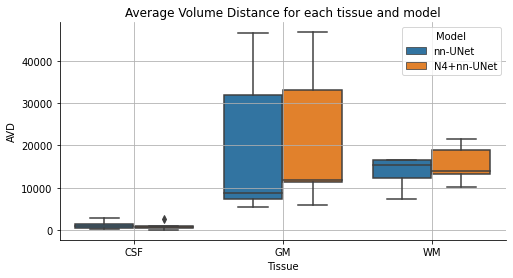

In [ ]:
df = pd.melt(avd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'AVD']

plt.figure(figsize=(8,4))
plt.title('Average Volume Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="AVD", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'AVD',]].groupby(['Model', 'Tissue']).mean()

AVD
Model      Tissue              
N4+nn-UNet CSF       983.465809
           GM      21842.350109
           WM      15540.280116
nn-UNet    CSF      1182.778696
           GM      19993.431547
           WM      13625.385344

In [ ]:
df[['Model', 'Tissue', 'AVD',]].groupby(['Model', 'Tissue']).std()

AVD
Model      Tissue              
N4+nn-UNet CSF       972.986321
           GM      17378.988370
           WM       4590.687383
nn-UNet    CSF       980.273636
           GM      18307.825333
           WM       3937.874346

# Task 4: 2D U-Net with Full Data and 5-Fold CV

In this task (ID=502), we will retrain the 2D U-Net with 5-Fold cross validation and the combined training and validation images. Giving the model more data to train. 

## Structuring the task directory

In [ ]:
task_name = 'Task502_misa_fp' 
nnunet_dir = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
main_dir = os.path.join(base_dir,'nnUNet/nnunet')

In [ ]:
make_if_dont_exist(task_folder_name,overwrite = False)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir,overwrite= False)
make_if_dont_exist(os.path.join(main_dir,'nnunet_trained_models'))

nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task502_misa_fp exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task502_misa_fp/imagesTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task502_misa_fp/labelsTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task502_misa_fp/imagesTs exists.
/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnunet_trained_models exists.


## Environment variables

In [ ]:
os.environ['nnUNet_raw_data_base'] = os.path.join(main_dir,'nnUNet_raw_data_base')
os.environ['nnUNet_preprocessed'] = os.path.join(main_dir,'preprocessed')
os.environ['RESULTS_FOLDER'] = os.path.join(main_dir,'nnUNet_trained_models')

## Parsing the data

In [ ]:
train_dir = '/content/drive/MyDrive/misa_fp/data/Training_Set'
val_dir = '/content/drive/MyDrive/misa_fp/data/Validation_Set'
test_dir_or = '/content/drive/MyDrive/misa_fp/data/Test_Set'

In [ ]:
for sample_id in os.listdir(train_dir):
  sample_location = os.path.join(train_dir, sample_id)
  img_name = f'{sample_id}.nii.gz'
  mask_name = f'{sample_id}_seg.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality
  new_mask_name = f'{sample_id}.nii.gz'

  # copy image to task folder
  copy_and_rename(sample_location, img_name, train_image_dir, new_img_name)
  # copy label to task folder
  copy_and_rename(sample_location, mask_name, train_label_dir, new_mask_name)
  print(f'{sample_id} copied')

IBSR_03 copied
IBSR_09 copied
IBSR_05 copied
IBSR_04 copied
IBSR_16 copied
IBSR_06 copied
IBSR_08 copied
IBSR_01 copied
IBSR_07 copied
IBSR_18 copied


In [ ]:
for sample_id in os.listdir(val_dir):
  sample_location = os.path.join(val_dir, sample_id)
  img_name = f'{sample_id}.nii.gz'
  mask_name = f'{sample_id}_seg.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality
  new_mask_name = f'{sample_id}.nii.gz'

  # copy image to task folder
  copy_and_rename(sample_location, img_name, train_image_dir, new_img_name)
  # copy label to task folder
  copy_and_rename(sample_location, mask_name, train_label_dir, new_mask_name)
  print(f'{sample_id} copied')

IBSR_13 copied
IBSR_14 copied
IBSR_11 copied
IBSR_17 copied
IBSR_12 copied


In [ ]:
for sample_id in os.listdir(test_dir_or):
  sample_location = os.path.join(test_dir_or, sample_id)
  img_name = f'{sample_id}.nii.gz'

  new_img_name = f'{sample_id}_0000.nii.gz' #0000 for modality

  # copy image to task folder
  copy_and_rename(sample_location, img_name, test_dir, new_img_name)

  print(f'{sample_id} copied')

IBSR_02 copied
IBSR_10 copied
IBSR_15 copied


Creating dataset.json

In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['description'] = "MISA Final Project Dataset: Brain tissue segmentation from MRI, 2D with all data"
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = "see challenge website"
    json_dict['licence'] = "see challenge website"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['modality'] = {
        "0": "MRI"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "0": "background",
        "1": "CSF",
        "2": "GM",
        "3": "WM"
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    #removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]

    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json created!


Check dataset

In [ ]:
#running it from the experiment_planning folder to verify the path settings
os.chdir(main_dir)
!python experiment_planning/nnUNet_plan_and_preprocess.py -t 502 --verify_dataset_integrity
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case IBSR_03
checking case IBSR_09
checking case IBSR_05
checking case IBSR_04
checking case IBSR_16
checking case IBSR_06
checking case IBSR_08
checking case IBSR_01
checking case IBSR_07
checking case IBSR_18
checking case IBSR_13
checking case IBSR_14
checking case IBSR_11
checking case IBSR_17
checking case IBSR_12
Verifying label values
Expected label values are [0, 1, 2, 3]
Labels OK
Verifying test set
Dataset OK
IBSR_03
IBSR_09
IBSR_05
IBSR_04
IBSR_16
IBSR_06
IBSR_08
IBSR_01
before crop: (1, 256, 128, 256) after crop: (1, 130, 109, 135) spacing: [1.  1.5 1. ] 

before crop: (1, 256, 128, 256)

## Train

### Fold 1

In [ ]:
# First fold => Done
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Fast 502 0
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spaci

### Fold 2

In [ ]:
# Second fold (stopped ar epoch 2)
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Fast 502 1
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spaci

In [ ]:
# Second fold (resume from epoch 3
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Fast 502 1 -c
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spaci

### Fold 3

In [ ]:
# Third fold
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Fast 502 2
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spaci

In [ ]:
# Third fold (continue)
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Fast 502 2 -c
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spaci

In [ ]:
# Third fold (continue 2)
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Fast 502 2 -c
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spaci

### Fold 4

In [ ]:
# Fourth fold
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Fast 502 3
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spaci

### Fold 5

In [ ]:
# Fifth fold
os.chdir(main_dir)
!nnUNet_train 2d nnUNetTrainerV2_Fast 502 4
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2_Fast.nnUNetTrainerV2_Fast'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 69, 'num_pool_per_axis': [5, 5], 'patch_size': array([160, 160]), 'median_patient_size_in_voxels': array([115, 139, 147]), 'current_spaci

## consolidate folds

In [ ]:
!nnUNet_determine_postprocessing -t 502 -m 2d



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Foreground vs background
before: 0.9296842220729112
after:  0.9296850428108531
Removing all but the largest foreground region improved results!
for_which_classes [1, 2, 3]
min_valid_object_sizes None
1
before: 0.9030122837619419
after:  0.8395722126543189
2
before: 0.9477696676922232
after:  0.9477880671161879
Removing all but the largest region for class 2 improved results!
min_valid_object_sizes None
3
before: 0.9382731769783942
after:  0.8909039885024522
done
for which classes:
[[1, 2, 3], 2]
min_object_sizes
None
done


## CV results

In [ ]:
gt_path = '/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task503_misa_fp/nnUNetTrainerV2__nnUNetPlansv2.1/gt_niftis'
preds_path = '/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task502_misa_fp/nnUNetTrainerV2__nnUNetPlansv2.1/cv_niftis_postprocessed'
img_list = ['IBSR_03', 'IBSR_09', 'IBSR_05', 'IBSR_04', 'IBSR_16', 'IBSR_06', 'IBSR_08', 'IBSR_01', 'IBSR_07', 'IBSR_18', 'IBSR_13', 'IBSR_14', 'IBSR_11', 'IBSR_17', 'IBSR_12']
avd_list = []
hd_list = []
ravd_list = []
dice_list = []

In [ ]:
# Task 4
for img_id in img_list:
  gt = sitk.ReadImage(f'{gt_path}/{img_id}.nii.gz')
  vspace = gt.GetSpacing()
  gt = sitk.GetArrayFromImage(gt)
  pred = sitk.GetArrayFromImage(sitk.ReadImage(f'{preds_path}/{img_id}.nii.gz'))

  hd_list.append(haussdorf(gt, pred, vspace) + [img_id , 'nn-UNet'])
  avd_list.append(avd(gt, pred, vspace) + [img_id, 'nn-UNet'])
  ravd_list.append(rel_abs_vol_dif(gt, pred) + [img_id, 'nn-UNet'])
  dice_list.append(dice_score(gt, pred) + [img_id, 'nn-UNet'])

In [ ]:
columns = ['CSF', 'GM', 'WM', 'Case', 'Model']
dice_scores_df = pd.DataFrame(data=dice_list, columns=columns)
dice_scores_df.to_csv('/content/drive/MyDrive/misa_fp/results/dice_cv_4.csv')

avd_df = pd.DataFrame(data=avd_list, columns=columns)
avd_df.to_csv('/content/drive/MyDrive/misa_fp/results/avd_cv_4.csv')

ravd_df = pd.DataFrame(data=ravd_list, columns=columns)
ravd_df.to_csv('/content/drive/MyDrive/misa_fp/results/ravd_cv_4.csv')

hd_df = pd.DataFrame(data=hd_list, columns=columns)
hd_df.to_csv('/content/drive/MyDrive/misa_fp/results/hd_cv_4.csv')

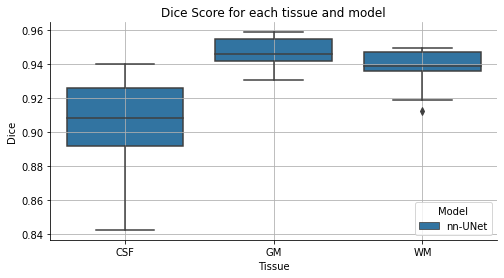

In [ ]:
df = pd.melt(dice_scores_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'Dice']

plt.figure(figsize=(8,4))
plt.title('Dice Score for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="Dice", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'Dice',]].groupby(['Model', 'Tissue']).mean()

Dice
Model   Tissue          
nn-UNet CSF     0.903012
        GM      0.947788
        WM      0.938273

In [ ]:
df[['Model', 'Tissue', 'Dice',]].groupby(['Model', 'Tissue']).std()

Dice
Model   Tissue          
nn-UNet CSF     0.028874
        GM      0.007995
        WM      0.010493

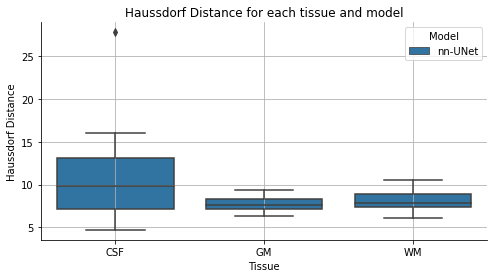

In [ ]:
df = pd.melt(hd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'Haussdorf Distance']

plt.figure(figsize=(8,4))
plt.title('Haussdorf Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="Haussdorf Distance", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'Haussdorf Distance',]].groupby(['Model', 'Tissue']).mean()

Haussdorf Distance
Model   Tissue                    
nn-UNet CSF              10.874963
        GM                7.654710
        WM                8.110614

In [ ]:
df[['Model', 'Tissue', 'Haussdorf Distance',]].groupby(['Model', 'Tissue']).std()

Haussdorf Distance
Model   Tissue                    
nn-UNet CSF               5.909838
        GM                0.980712
        WM                1.256613

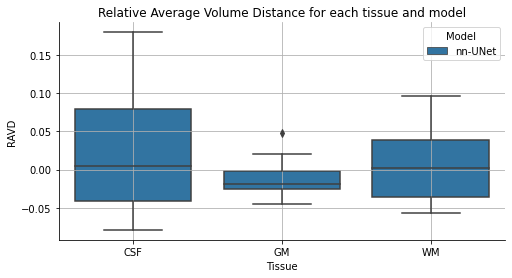

In [ ]:
df = pd.melt(ravd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'RAVD']

plt.figure(figsize=(8,4))
plt.title('Relative Average Volume Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="RAVD", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'RAVD',]].groupby(['Model', 'Tissue']).mean()

RAVD
Model   Tissue          
nn-UNet CSF     0.023042
        GM     -0.011230
        WM      0.005458

In [ ]:
df[['Model', 'Tissue', 'RAVD',]].groupby(['Model', 'Tissue']).std()

RAVD
Model   Tissue          
nn-UNet CSF     0.077939
        GM      0.024518
        WM      0.044694

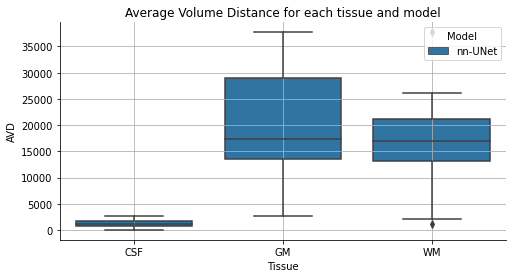

In [ ]:
df = pd.melt(avd_df, id_vars=['Model', 'Case'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df.columns = ['Model', 'Case', 'Tissue', 'AVD']

plt.figure(figsize=(8,4))
plt.title('Average Volume Distance for each tissue and model')
sns.boxplot(data=df, x="Tissue", y="AVD", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='upper right', title='Model')
plt.show()

In [ ]:
df[['Model', 'Tissue', 'AVD',]].groupby(['Model', 'Tissue']).mean()

AVD
Model   Tissue              
nn-UNet CSF      1243.820611
        GM      19822.766511
        WM      17022.742811

In [ ]:
df[['Model', 'Tissue', 'AVD',]].groupby(['Model', 'Tissue']).std()

AVD
Model   Tissue              
nn-UNet CSF       848.914963
        GM      10924.226927
        WM       8875.021261

# Inference on Test images

In [ ]:
task_name = 'Task502_misa_fp'

In [ ]:
result_dir = os.path.join(main_dir,'nnUNet_Prediction_Results_Final', task_name)
make_if_dont_exist(result_dir)
team_name = 'JoaKaou'
#location where you want save your results, will be created if dont exist
os.chdir(main_dir)
!nnUNet_predict -i /content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task502_misa_fp/imagesTs -o nnUNet_Prediction_Results_Final/Task502_misa_fp -t 502 -tr nnUNetTrainerV2 -m 2d --num_threads_preprocessing 1
os.chdir(base_dir)

/content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_Prediction_Results_Final/Task502_misa_fp exists.


Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/drive/MyDrive/misa_fp/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task502_misa_fp/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 3 unique case ids, here are some examples: ['IBSR_15' 'IBSR_15' 'IBSR_10']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 3
number of cases that still need to be predicted: 0
emptying cuda cache
loading parameters for folds, None
folds is None so we will 

## Visualization

Test Image Shape:  (256, 128, 10, 1)
Predicted Image Shape: (256, 128, 10)


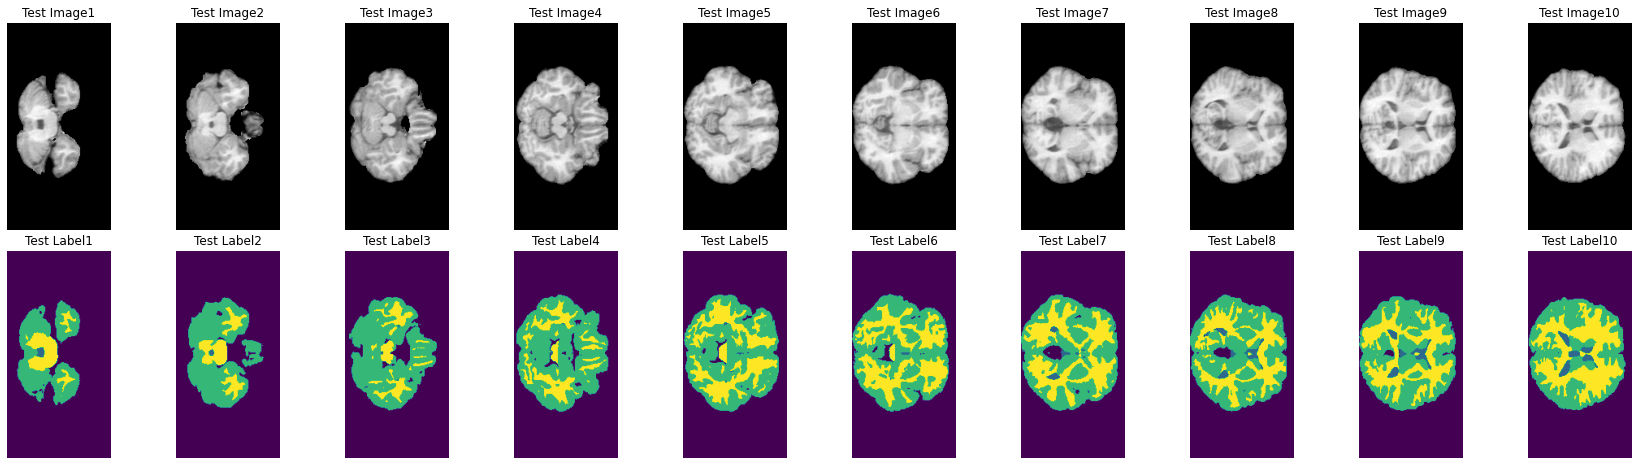

In [ ]:
#visualizing the predicted results
# (re-run to see random pick-ups)
result_dir = os.path.join(main_dir,'nnUNet_Prediction_Results_Final',task_name)
test_img_name = os.listdir(test_dir)[np.random.randint(0,3)]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:,100:150:5]
predicted_img_name = test_img_name[:test_img_name.find('_0000.nii.gz')]+'.nii.gz'
predicted_label = np.array(nib.load(os.path.join(result_dir,predicted_img_name)).dataobj)[:,:,100:150:5]
print('Test Image Shape: ',test_img.shape)
print("Predicted Image Shape:",predicted_label.shape)

max_rows = 2
max_cols = test_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,8))
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Test Image'+str(idx+1))
    axes[0 ,idx].imshow(test_img[:,:,idx].squeeze(), cmap="gray")
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Test Label'+str(idx+1))
    axes[1, idx].imshow(predicted_label[:,:,idx].squeeze())
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

Test Image Shape:  (256, 10, 256, 1)
Predicted Image Shape: (256, 10, 256)
Test Image Shape:  (256, 256, 10, 1)
Predicted Image Shape: (256, 256, 10)


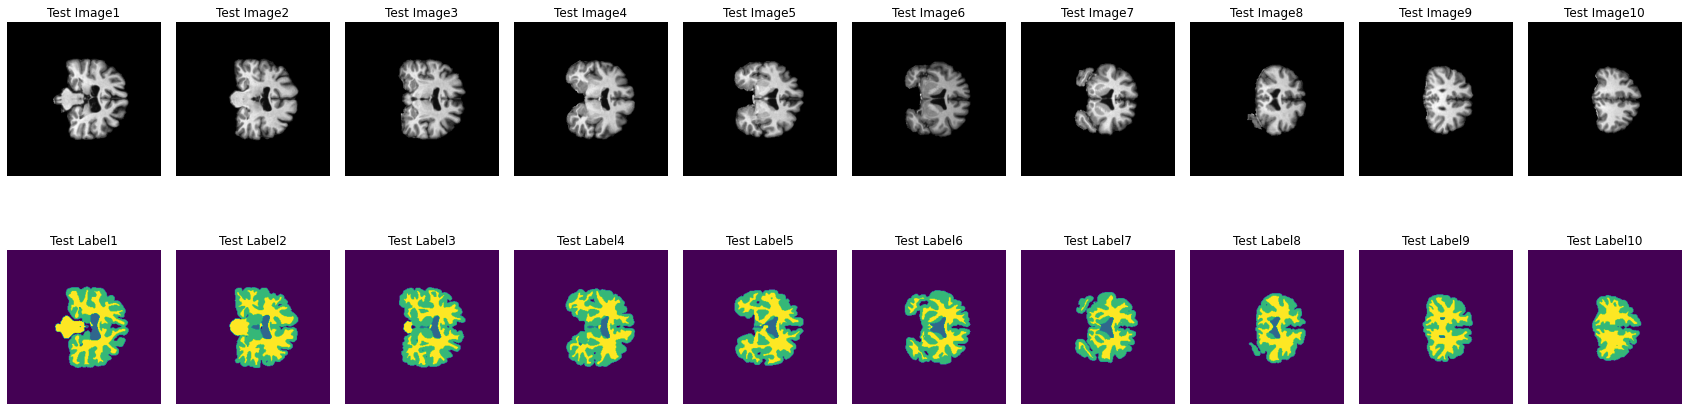

In [ ]:
#visualizing the predicted results
# (re-run to see random pick-ups)
result_dir = os.path.join(main_dir,'nnUNet_Prediction_Results_Final',task_name)
test_img_name = os.listdir(test_dir)[np.random.randint(0,2)]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,50:100:5,:]
predicted_img_name = test_img_name[:test_img_name.find('_0000.nii.gz')]+'.nii.gz'
predicted_label = np.array(nib.load(os.path.join(result_dir,predicted_img_name)).dataobj)[:,50:100:5,:]

print('Test Image Shape: ',test_img.shape)
print("Predicted Image Shape:",predicted_label.shape)

predicted_label = predicted_label.transpose(0, 2, 1)
test_img = test_img.transpose(0, 2, 1, 3)

print('Test Image Shape: ',test_img.shape)
print("Predicted Image Shape:",predicted_label.shape)

max_rows = 2
max_cols = test_img.shape[2]
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,8))
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Test Image'+str(idx+1))
    axes[0 ,idx].imshow(test_img[:,:,idx].squeeze(), cmap="gray")
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Test Label'+str(idx+1))
    axes[1, idx].imshow(predicted_label[:,:,idx].squeeze())
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()